In [45]:
import pandas as pd
import numpy as np

import modelos as md
import funcoes as fc
from importlib import reload
reload(md)
reload(fc)

<module 'funcoes' from 'c:\\Users\\bergs\\OneDrive\\Área de Trabalho\\UFPB\\Quinto Periodo\\Machine Learning\\repositorio\\Reconhecimento-de-digitos-ML-2023.2\\funcoes.py'>

In [46]:
dataframe_treino = pd.read_csv('arquivos_csv/train_redu.csv', sep=';')
dataframe_teste = pd.read_csv('arquivos_csv/test_reduzido.csv', sep=';')

# Tratamento dos dados

In [47]:
# Obtendo os valores de treino e teste
X = dataframe_treino[['intensidade', 'simetria']].values
X_teste = dataframe_teste[['intensidade', 'simetria']].values
Y = dataframe_treino['label'].values
y_teste = dataframe_teste['label'].values

# Transformando os dados e alterando os valores de label para 1 e -1
X = fc.padronizar_normal(X)
X_teste = fc.padronizar_normal(X_teste)
# Adicionando uma coluna de 1s
X = np.c_[np.ones(len(X)), X]
X_teste = np.c_[np.ones(len(X_teste)), X_teste]

# Usando a Regressão Logística

Digito: 0
Acuracia do treino: 99.35956084172004
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[1761    0]
 [  14  411]]
              precision    recall  f1-score   support

          -1       0.99      1.00      1.00      1761
           0       1.00      0.97      0.98       425

    accuracy                           0.99      2186
   macro avg       1.00      0.98      0.99      2186
weighted avg       0.99      0.99      0.99      2186

Gráfico de treino


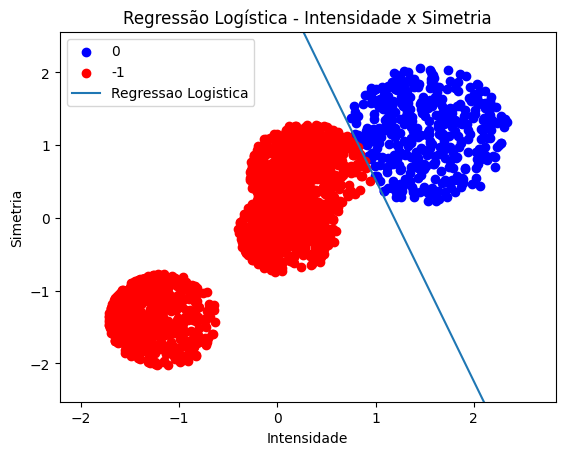

Digito: 0
Acuracia do teste: 99.28251121076234
Matriz de confusão do teste, os valores do digito estao na linha de baixo
[[897   0]
 [  8 210]]
              precision    recall  f1-score   support

          -1       0.99      1.00      1.00       897
           0       1.00      0.96      0.98       218

    accuracy                           0.99      1115
   macro avg       1.00      0.98      0.99      1115
weighted avg       0.99      0.99      0.99      1115

Gráfico de teste


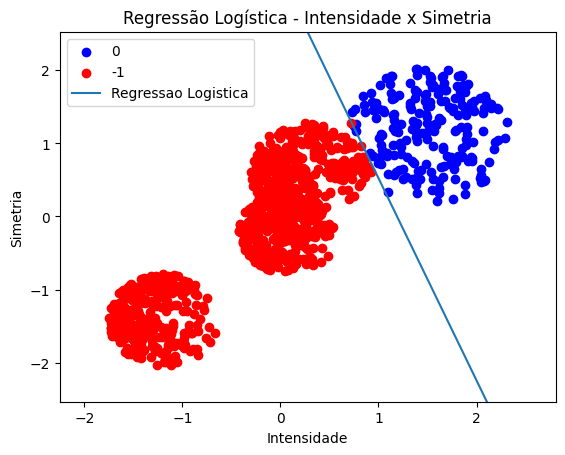

Digito: 1
Acuracia do treino: 100.0
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[1167    0]
 [   0  608]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1167
           1       1.00      1.00      1.00       608

    accuracy                           1.00      1775
   macro avg       1.00      1.00      1.00      1775
weighted avg       1.00      1.00      1.00      1775

Gráfico de treino


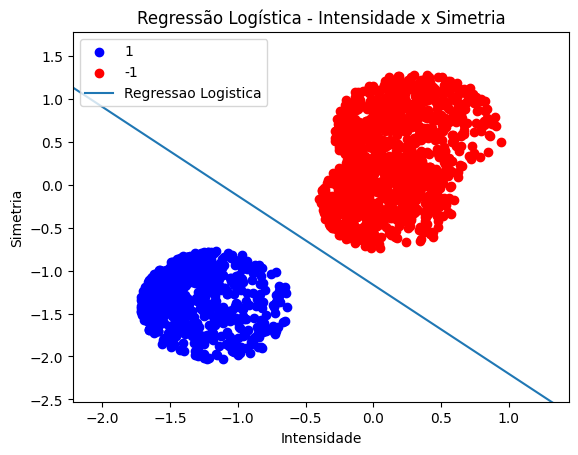

Digito: 1
Acuracia do teste: 100.0
Matriz de confusão do teste, os valores do digito estao na linha de baixo
[[613   0]
 [  0 292]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       613
           1       1.00      1.00      1.00       292

    accuracy                           1.00       905
   macro avg       1.00      1.00      1.00       905
weighted avg       1.00      1.00      1.00       905

Gráfico de teste


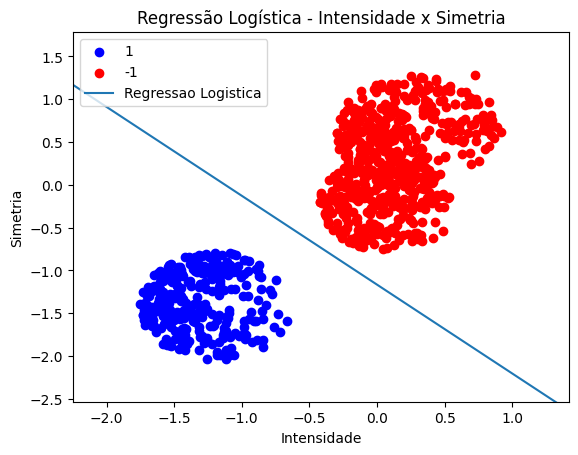

Digito: 4
Acuracia do treino: 92.45929734361611
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[549  41]
 [ 47 530]]
              precision    recall  f1-score   support

          -1       0.92      0.93      0.93       590
           4       0.93      0.92      0.92       577

    accuracy                           0.92      1167
   macro avg       0.92      0.92      0.92      1167
weighted avg       0.92      0.92      0.92      1167

Gráfico de treino


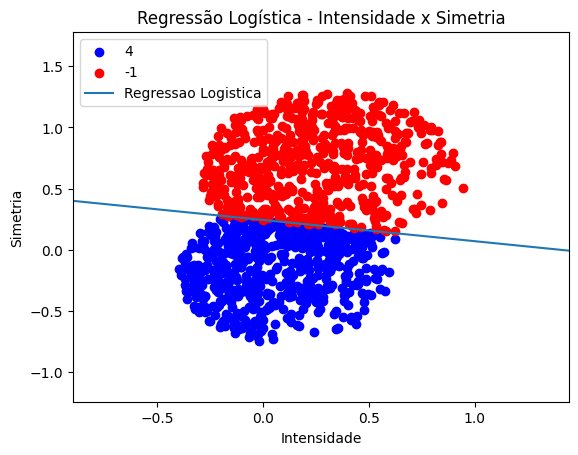

Digito: 4
Acuracia do teste: 94.45350734094616
Matriz de confusão do teste, os valores do digito estao na linha de baixo
[[280  19]
 [ 15 299]]
              precision    recall  f1-score   support

          -1       0.95      0.94      0.94       299
           4       0.94      0.95      0.95       314

    accuracy                           0.94       613
   macro avg       0.94      0.94      0.94       613
weighted avg       0.94      0.94      0.94       613

Gráfico de teste


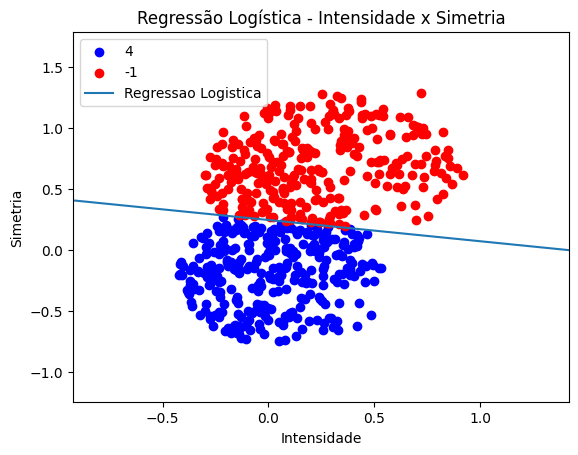

In [48]:
digitos = [0,1,4]
fc.classificador_de_todos_os_digitos_Rlog(X, Y, X_teste, y_teste, digitos)


# Usando a Regressão Linear

Digito: 1
Acuracia do treino: 100.0
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[1578    0]
 [   0  608]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1578
           1       1.00      1.00      1.00       608

    accuracy                           1.00      2186
   macro avg       1.00      1.00      1.00      2186
weighted avg       1.00      1.00      1.00      2186

Gráfico de treino


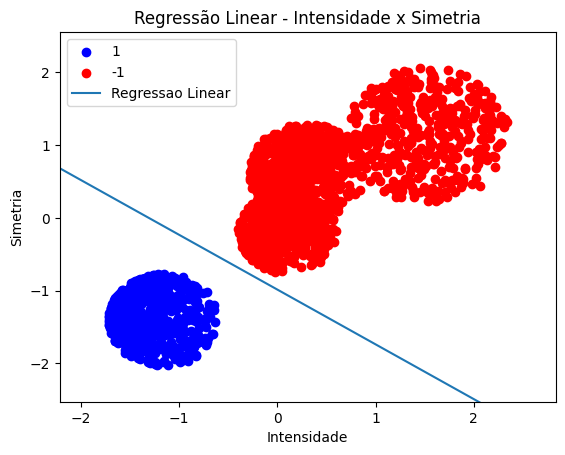

Digito: 1
Acuracia do teste: 100.0
[[823   0]
 [  0 292]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       823
           1       1.00      1.00      1.00       292

    accuracy                           1.00      1115
   macro avg       1.00      1.00      1.00      1115
weighted avg       1.00      1.00      1.00      1115

Gráfico de teste


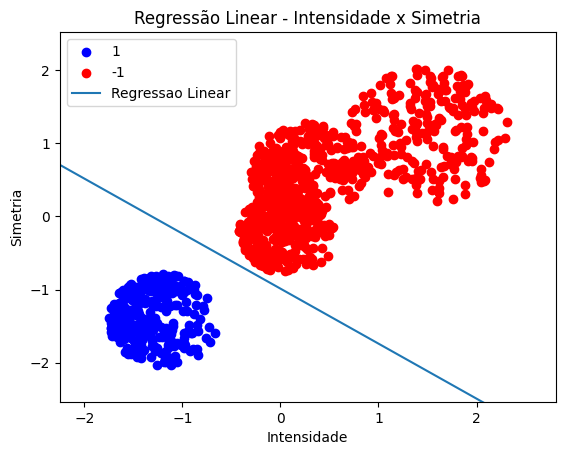

Digito: 4
Acuracia do treino: 94.16983523447402
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[927  74]
 [ 18 559]]
              precision    recall  f1-score   support

          -1       0.98      0.93      0.95      1001
           4       0.88      0.97      0.92       577

    accuracy                           0.94      1578
   macro avg       0.93      0.95      0.94      1578
weighted avg       0.95      0.94      0.94      1578

Gráfico de treino


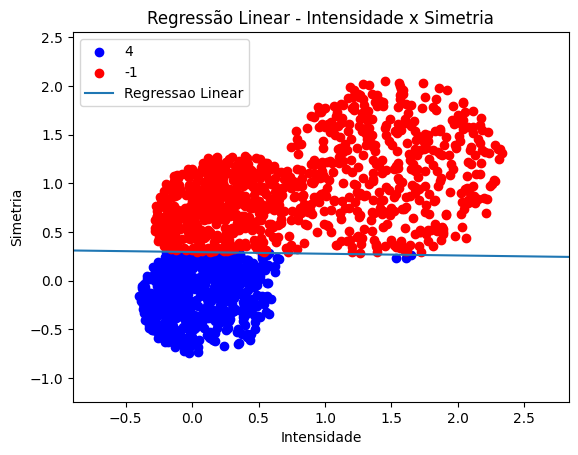

Digito: 4
Acuracia do teste: 95.62575941676792
[[476  33]
 [  3 311]]
              precision    recall  f1-score   support

          -1       0.99      0.94      0.96       509
           4       0.90      0.99      0.95       314

    accuracy                           0.96       823
   macro avg       0.95      0.96      0.95       823
weighted avg       0.96      0.96      0.96       823

Gráfico de teste


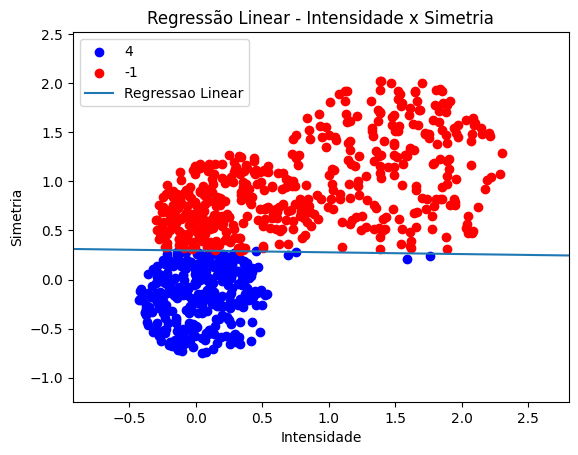

Digito: 0
Acuracia do treino: 97.98941798941799
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[523   0]
 [ 19 403]]
              precision    recall  f1-score   support

          -1       0.96      1.00      0.98       523
           0       1.00      0.95      0.98       422

    accuracy                           0.98       945
   macro avg       0.98      0.98      0.98       945
weighted avg       0.98      0.98      0.98       945

Gráfico de treino


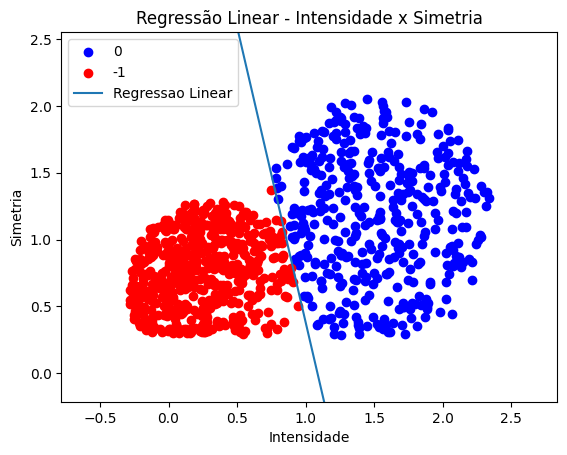

Digito: 0
Acuracia do teste: 97.4947807933194
[[263   0]
 [ 12 204]]
              precision    recall  f1-score   support

          -1       0.96      1.00      0.98       263
           0       1.00      0.94      0.97       216

    accuracy                           0.97       479
   macro avg       0.98      0.97      0.97       479
weighted avg       0.98      0.97      0.97       479

Gráfico de teste


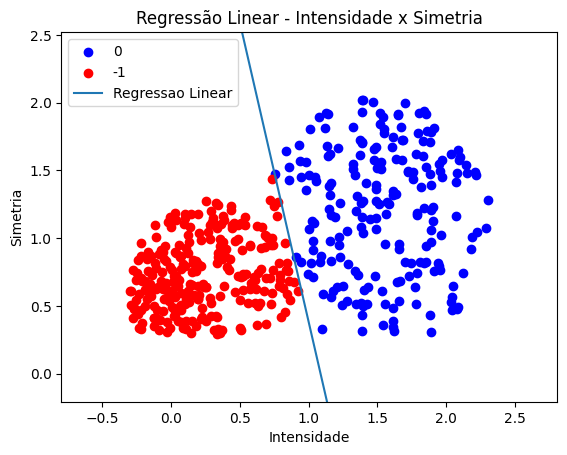

In [49]:
digitos = [1,4,0]
modelo = md.RegressaoLinear()
fc.classificador_de_todos_os_digitos(X, Y, X_teste, y_teste, digitos, modelo)



# Usando Perceptron

Digito: 0
Acuracia do treino: 97.94144556267155
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[1761    0]
 [  45  380]]
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99      1761
           0       1.00      0.89      0.94       425

    accuracy                           0.98      2186
   macro avg       0.99      0.95      0.97      2186
weighted avg       0.98      0.98      0.98      2186

Gráfico de treino


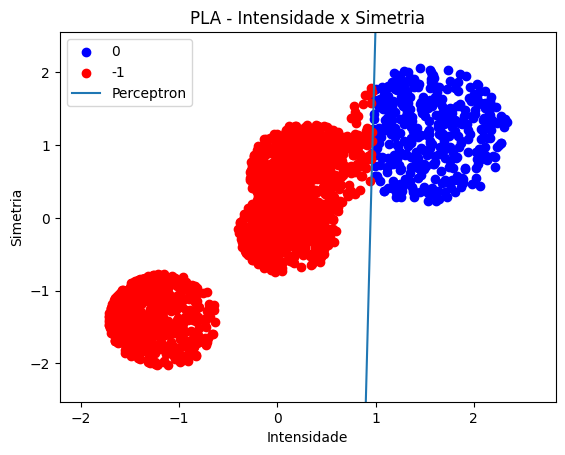

Digito: 0
Acuracia do teste: 98.02690582959642
[[897   0]
 [ 22 196]]
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99       897
           0       1.00      0.90      0.95       218

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115

Gráfico de teste


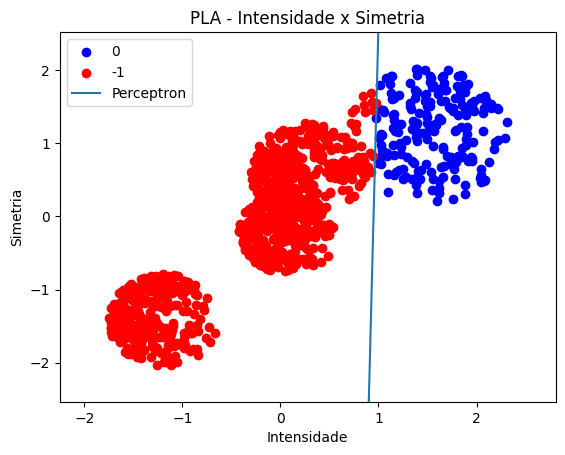

Digito: 1
Acuracia do treino: 100.0
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[1198    0]
 [   0  608]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1198
           1       1.00      1.00      1.00       608

    accuracy                           1.00      1806
   macro avg       1.00      1.00      1.00      1806
weighted avg       1.00      1.00      1.00      1806

Gráfico de treino


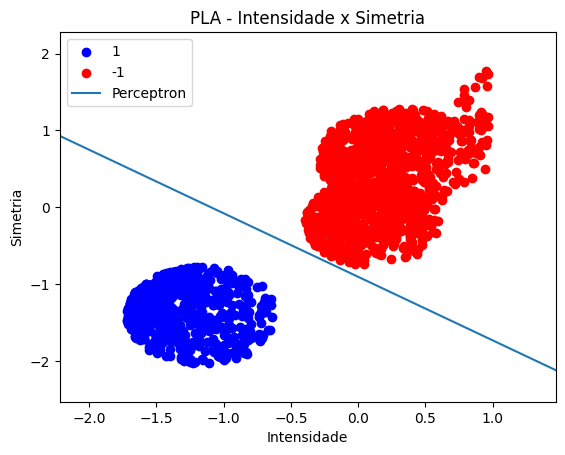

Digito: 1
Acuracia do teste: 100.0
[[627   0]
 [  0 292]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       627
           1       1.00      1.00      1.00       292

    accuracy                           1.00       919
   macro avg       1.00      1.00      1.00       919
weighted avg       1.00      1.00      1.00       919

Gráfico de teste


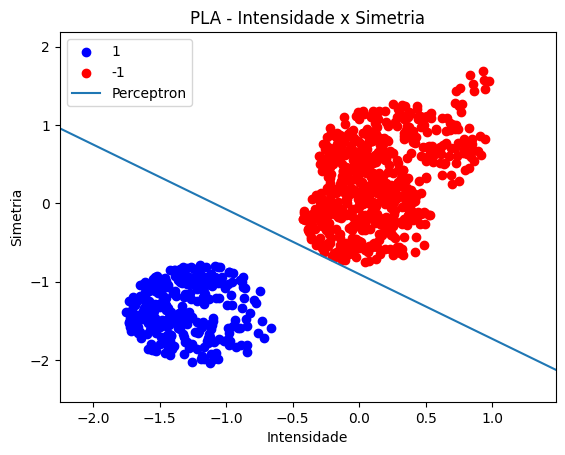

Digito: 4
Acuracia do treino: 82.0534223706177
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[621   0]
 [215 362]]
              precision    recall  f1-score   support

          -1       0.74      1.00      0.85       621
           4       1.00      0.63      0.77       577

    accuracy                           0.82      1198
   macro avg       0.87      0.81      0.81      1198
weighted avg       0.87      0.82      0.81      1198

Gráfico de treino


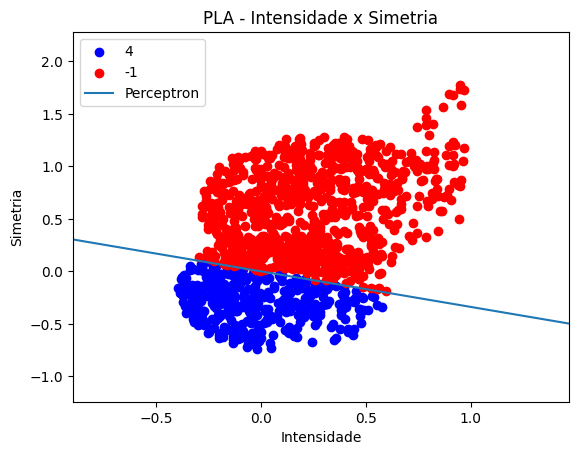

Digito: 4
Acuracia do teste: 83.73205741626795
[[313   0]
 [102 212]]
              precision    recall  f1-score   support

          -1       0.75      1.00      0.86       313
           4       1.00      0.68      0.81       314

    accuracy                           0.84       627
   macro avg       0.88      0.84      0.83       627
weighted avg       0.88      0.84      0.83       627

Gráfico de teste


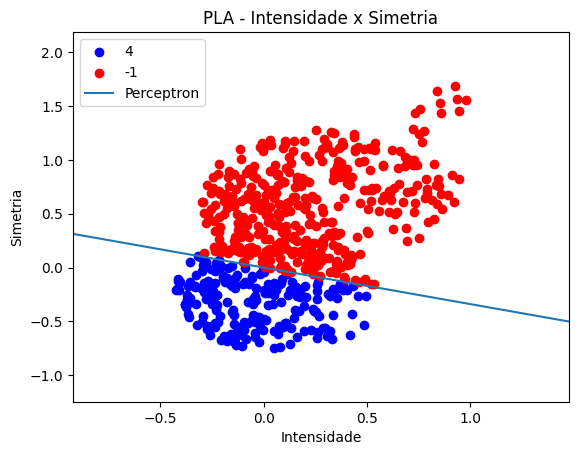

In [50]:
digitos = [0,1,4]
modelo = md.PLA()
fc.classificador_de_todos_os_digitos(X, Y, X_teste, y_teste, digitos, modelo)